```
    Design a
    Network with Group Normalization
    Network with Layer Normalization
    Network with L1 + BN

Instructions:
    Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
    Write a single notebook file to run all the 3 models above for 20 epochs each
    Create these graphs:
        Graph 1: Test/Validation Loss for all 3 models together
        Graph 2: Test/Validation Accuracy for 3 models together
        graphs must have proper annotation
    Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 
```




# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine(degrees=15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  transforms.RandomErasing()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from enum import Enum
class Regulaization(Enum):
  BNORM = 'BN'
  LNORM = 'LN'
  GNORM = 'GN'


In [ ]:
type(Regulaization.BNORM.name)

str

# The model
Let's start with the model we first saw

In [ ]:

import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
  def __init__(self,regularization_type=Regulaization.BNORM,group_num=1):
      super(Net, self).__init__()
      self.regularizer = regularization_type
      self.group_num = group_num
      self.conv1 = nn.Sequential(
          nn.Conv2d(1, 8, 3,bias=False),  
          nn.ReLU(),
          self.add_regularizer(8),
          # nn.BatchNorm2d(8),

          nn.Conv2d(8, 16, 3,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(16),
          # nn.BatchNorm2d(16),
      )
      self.pool1 = nn.MaxPool2d(2,2)
      self.trans1 = nn.Sequential(
          nn.Conv2d(16, 8, 1,bias=False),
          nn.ReLU(),
      )
      self.conv2 =  nn.Sequential(
          nn.Conv2d(8, 8, 3,bias=False), 
          nn.ReLU(),
          self.add_regularizer(8),
          # nn.BatchNorm2d(8),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(8, 16, 3,bias=False),  
          nn.ReLU(),
          self.add_regularizer(16),
          # nn.BatchNorm2d(16),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(16, 24, 3,bias=False),
          nn.ReLU(),
          self.add_regularizer(24),
          # nn.BatchNorm2d(24),
          nn.Dropout2d(dropout_value), 
      )
      
      self.trans2 = nn.Sequential(
          nn.Conv2d(24, 24, 1,bias=False),
          nn.ReLU(),
      )
      self.conv3 = nn.Sequential(
          nn.Conv2d(8, 24, 3,bias=False),
          nn.ReLU(),
          self.add_regularizer(24),
          # nn.BatchNorm2d(24),
          nn.Dropout2d(dropout_value),    
      )
      self.gap = nn.Sequential(
          nn.AvgPool2d(6)
      )

      self.conv4 = nn.Sequential(
          nn.Conv2d(24, 16, 1,bias=False),
          nn.ReLU(),
          self.add_regularizer(16),)
          # nn.BatchNorm2d(16),)
      self.conv5 = nn.Sequential(nn.Conv2d(16,10,1,bias=False))

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.trans1(x)
    x = self.conv2(x)
    x = self.trans2(x)
    # x = self.conv3(x)
    x = self.gap(x)
    x = self.conv4(x)
    x = self.conv5(x)
    # print(x.shape)
    x = x.view(-1,10)
    # x = self.fc(x)
    # print(x.shape)
    return F.log_softmax(x,dim=-1)

  def add_regularizer(self,out_channel):
    """
    Returns regulaizer BN/LN/GN
    """
    if self.regularizer == Regulaization.BNORM:
      return nn.BatchNorm2d(out_channel)
    elif self.regularizer == Regulaization.LNORM:
      return nn.GroupNorm(1,out_channel)
    return nn.GroupNorm(self.group_num,out_channel)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(Regulaization.GNORM,2).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 26, 26]           1,152
              ReLU-5           [-1, 16, 26, 26]               0
         GroupNorm-6           [-1, 16, 26, 26]              32
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             128
              ReLU-9            [-1, 8, 13, 13]               0
           Conv2d-10            [-1, 8, 11, 11]             576
             ReLU-11            [-1, 8, 11, 11]               0
        GroupNorm-12            [-1, 8, 11, 11]              16
        Dropout2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch,loss_function,lambda_val=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_function(model,y_pred, target,lambda_val)
    # loss = F.nll_loss(y_pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader,loss_function,lambda_val=0):
    model.eval()
    test_loss = 0
    correct = 0
    wrong_images = []
    correct_label = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(model,output, target,lambda_val,'sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            wrong_pred = (pred.eq(target.view_as(pred)) == False)
            wrong_images.append(data[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    test_acc.append(acc)
    return acc,test_loss,wrong_images,correct_label

In [ ]:
def loss_fn(model,pred,target,lambda_param=None,reduction_type='mean'):
  loss = F.nll_loss(pred,target,reduction=reduction_type)
  if lambda_param:
    # print('here')
    l1 = 0
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    loss = loss + lambda_param*l1
  return loss

In [ ]:
from collections import defaultdict
result_dict = defaultdict(dict)

In [ ]:
from torch.optim.lr_scheduler import StepLR

model_initilizer_list = [Regulaization.GNORM,Regulaization.LNORM,Regulaization.BNORM]
group_num = 4
for current_model_initilizer in model_initilizer_list:
  model =  Net(current_model_initilizer,group_num).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
  EPOCHS = 15
  result_dict[current_model_initilizer] = defaultdict(list)
  lambda_val = 0
  if current_model_initilizer == Regulaization.BNORM:
    lambda_val = 0.009
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,loss_fn,lambda_val)
      scheduler.step()
      acc,loss,wrong_images,correct_label = test(model, device, test_loader,loss_fn,lambda_val)
      result_dict[current_model_initilizer]['acc'].append(acc)
      result_dict[current_model_initilizer]['loss'].append(loss)
  result_dict[current_model_initilizer]['wrong_img'] = wrong_images
  result_dict[current_model_initilizer]['correct_label'] = correct_label

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07086062431335449 Batch_id=468 Accuracy=85.67: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1050, Accuracy: 9715/10000 (97.15%)

EPOCH: 1


Loss=0.10808483511209488 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.013228905387222767 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:30<00:00, 15.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.04711734130978584 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.04110729694366455 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:30<00:00, 15.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.01083999965339899 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.10176732391119003 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:30<00:00, 15.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.15039663016796112 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.05589153245091438 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.01903769187629223 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.008212666027247906 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:30<00:00, 15.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.007170164491981268 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.042092159390449524 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.015329242683947086 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:30<00:00, 15.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.028656547889113426 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

EPOCH: 0


Loss=0.09189027547836304 Batch_id=468 Accuracy=85.02: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0873, Accuracy: 9752/10000 (97.52%)

EPOCH: 1


Loss=0.12109461426734924 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.15388771891593933 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:30<00:00, 15.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9844/10000 (98.44%)

EPOCH: 3


Loss=0.036329615861177444 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:30<00:00, 15.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9861/10000 (98.61%)

EPOCH: 4


Loss=0.03008093871176243 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.11943164467811584 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.05149990692734718 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:31<00:00, 15.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.06029212847352028 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.018474744632840157 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.029165685176849365 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.0047720628790557384 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.05605176463723183 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.023954788222908974 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.00928750354796648 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:30<00:00, 15.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.02615313231945038 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9923/10000 (99.23%)

EPOCH: 0


Loss=1.9334774017333984 Batch_id=468 Accuracy=89.67: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4332, Accuracy: 8704/10000 (87.04%)

EPOCH: 1


Loss=1.1921451091766357 Batch_id=468 Accuracy=93.41: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6319, Accuracy: 7811/10000 (78.11%)

EPOCH: 2


Loss=1.0995115041732788 Batch_id=468 Accuracy=93.13: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3773, Accuracy: 6213/10000 (62.13%)

EPOCH: 3


Loss=0.9930112361907959 Batch_id=468 Accuracy=93.05: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4350, Accuracy: 8731/10000 (87.31%)

EPOCH: 4


Loss=0.7759411334991455 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1392, Accuracy: 9707/10000 (97.07%)

EPOCH: 5


Loss=0.8535560369491577 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2287, Accuracy: 9442/10000 (94.42%)

EPOCH: 6


Loss=0.7453534603118896 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:32<00:00, 14.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1191, Accuracy: 9741/10000 (97.41%)

EPOCH: 7


Loss=0.8156288266181946 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 9700/10000 (97.00%)

EPOCH: 8


Loss=0.7303712368011475 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9850/10000 (98.50%)

EPOCH: 9


Loss=0.708297610282898 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0827, Accuracy: 9843/10000 (98.43%)

EPOCH: 10


Loss=0.6840149164199829 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0815, Accuracy: 9849/10000 (98.49%)

EPOCH: 11


Loss=0.7286645770072937 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9843/10000 (98.43%)

EPOCH: 12


Loss=0.6199542880058289 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0746, Accuracy: 9858/10000 (98.58%)

EPOCH: 13


Loss=0.6315209269523621 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9859/10000 (98.59%)

EPOCH: 14


Loss=0.6572004556655884 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0750, Accuracy: 9867/10000 (98.67%)



In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
epochs = [x for x in range(0,15)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  This is separate from the ipykernel package so we can avoid doing imports until


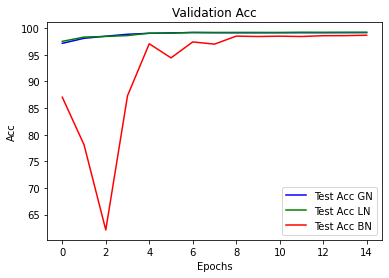

In [ ]:
color = ['B','G','R']
for i,current_model in enumerate(result_dict.keys()):
  plt.plot(epochs,result_dict[current_model]['acc'], color[i], label=f'Test Acc {current_model.value}')
  plt.title('Validation Acc')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
plt.show()

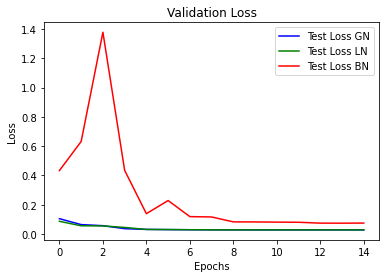

In [ ]:
color = ['B','G','R']
for i,current_model in enumerate(result_dict.keys()):
  plt.plot(epochs,result_dict[current_model]['loss'], color[i], label=f'Test Loss {current_model.value}')
  plt.title('Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
plt.show()

In [ ]:
def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 10
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('Misclassifications')
    for idx, image in enumerate(misclassified[:num_images]):
        image = image.cpu().numpy()
        print(image.shape)
        # ax = fig.add_subplot(5, 5, idx+1)
        # ax.axis('off')
        # # ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        # ax.imshow(image.squeeze())
    plt.show()

In [60]:
for i,current_model in enumerate(result_dict.keys()):
  # plot_misclassification(result_dict[current_model]['wrong_img'])
  print(result_dict[current_model]['correct_label'][0])

tensor([4, 6], device='cuda:0')
tensor([1, 9], device='cuda:0')
tensor([3], device='cuda:0')
